# Libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import radiomics
from radiomics import featureextractor
import cv2 as cv
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm import tqdm

In [2]:
features_path = Path.cwd()
notebooks_path = features_path.parent
repo_path = notebooks_path.parent
os.chdir(str(features_path))
#print current working directory
print(os.getcwd())

/home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Machine_Learning/notebooks/features


# Checking data
We first check which extraxction parameters we should use

In [3]:
class path_label():
    """Class to access paths and labels from csv
    """
    def __init__(self, meta=pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t'), classif='binary', set_name='train') -> None:
        meta = meta.loc[meta['classif'] == classif] #Filter by classif
        meta = meta.loc[meta['set'] == set_name] #Filter by set
        self.paths = list(meta.path)
        self. labels = np.array(meta.label)
        self.FOV_x1 = np.array(meta.FOV_x1, dtype=np.int16)
        self.FOV_x2 = np.array(meta.FOV_x2, dtype=np.int16)
        self.FOV_y1 = np.array(meta.FOV_y1, dtype=np.int16)
        self.FOV_y2 = np.array(meta.FOV_y2, dtype=np.int16)

In [4]:
#create class to call patient and its information
class patient():
    """Class to access patient information
    """
    def __init__(self, info = path_label(), num=0) -> None:
        self.path = info.paths[num]
        self.label = info.labels[num]
        self.FOV_x1 = info.FOV_x1[num]
        self.FOV_x2 = info.FOV_x2[num]
        self.FOV_y1 = info.FOV_y1[num]
        self.FOV_y2 = info.FOV_y2[num]
        self.image = cv.imread(str(repo_path) +"/"+ self.path)
        self.image = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        self.image = self.image[self.FOV_x1:self.FOV_x2, self.FOV_y1:self.FOV_y2]


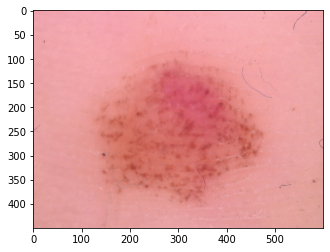

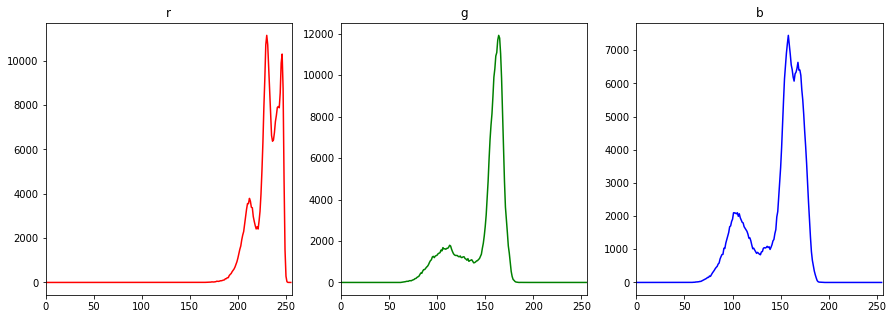

In [5]:
# Get data
info = path_label(classif='binary', set_name='train')
pat = patient(info=info, num=110)
#show BGR image using matplotlib
plt.imshow(pat.image)

#show RGB histogram of an image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, c in enumerate(['r', 'g', 'b']):
    hist = cv.calcHist([pat.image], [i], None, [256], [0, 256])
    ax[i].plot(hist, color=c)
    ax[i].set_title(c)
    ax[i].set_xlim([0, 256])

# Extractor

In [6]:
def extractor_setting():

  settings = {}
  settings['binWidth'] = 1 #To ensure a 1 pixel width for the histogram once the image has been requantized to 8 gray levels.
  settings['correctMask'] = True #To ensure the mask and the image are in the same coordinates
  # Instantiate the extractor
  extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
  extractor.disableAllFeatures()
  #Enable all first order features
  extractor.enableFeatureClassByName('firstorder')
  
  print('Extraction parameters:\n\t', extractor.settings)
  print('Enabled filters:\n\t', extractor.enabledImagetypes)
  print('Enabled features:\n\t', extractor.enabledFeatures)
  return extractor

def GLCM_for_folder(paths, f, tt, mag, num_features, extractor):
  """
  Definition: Extract feature vector for all images in a folder, saved as a pickle numpy matrix

  :param paths: paths of images
  :param f: fold number-1
  :param tt: train or test encoded
  :param mag: magnification encoded using dictionary
  :param num_features: Number of features ot be extracted. It defines the size of the feature matrix
  :param extractor: Pyradiomics extractor with presettings
  :return: NONE (Pickle file will be saved in drive)
  """

  paths_folder = paths[f,tt,mag] #Paths of the first folder (There are 40)
  n = len(paths_folder) #number of images (samples)
  feature_matrix = np.zeros((n,num_features),dtype=np.float32) #Shape of feature matrix set

  #Extraction of features
  for i in tqdm(range(n)):
    img_path = paths_folder[i] #Image from which features are extracted
    ft_v = GLCM_feature_im(img_path, extractor, num_features) #Returns feature vector of m-dimension
    feature_matrix[i,:] = ft_v
  #Saving document
  file_name = f'/content/drive/MyDrive/Ars_machinae_autodiscentis/Inceptum/fold{f+1}/{tt_dict[tt]}/GLCM_f{f+1}_{tt_dict[tt]}_{mag_dict[mag]}x_fv.p'
  with open(file_name, 'wb') as handle:
      pickle.dump(feature_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Imp

In [33]:
def colorStats_fromImage(im,extractor):
    #Empty numpy array to store feature vector
    fv = np.zeros(shape=(3,18),dtype=np.float64)
    for ch in range(3):
        im_ch = im[:,:,ch] #first channel image
        sitk_im = sitk.GetImageFromArray(im_ch) #Pass to sitk objet
        #mask
        mask = np.ones(im_ch.shape).astype(np.uint8) #Create maskwith same shape as image
        mask[-1,-1]=0 #Hack to allow full image segmentation. Last value is set to 0 so it wont be counted in the GLCM computation
        sitk_mask = sitk.GetImageFromArray(mask) #Pass to sitk object
        #Extract
        result = extractor.execute(sitk_im,sitk_mask) # Extract features
        features = np.array(list(result.values())[-18:]) #save as array 18 features
        fv[ch] = features
    
    return fv.ravel()

In [69]:
extractor= extractor_setting() #extractor settings 

classif='binary'; set_name='val'

info = path_label(classif=classif, set_name=set_name)
length = len(info.paths) #number of images

fv_matrix = np.zeros(shape=(length,54),dtype=np.float64) #Empty numpy array to store feature vectors
for i in tqdm(range(length)):
    pat = patient(info=info, num=i)
    fv_matrix[i] = colorStats_fromImage(pat.image, extractor)
    
ftype='color'; f_name='ColorStats'
with open(str(repo_path)+ f'/data/features/color/RGB/{classif}_{set_name}_{ftype}_{f_name}.p', 'wb') as handle:
    pickle.dump(fv_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 1, 'correctMask': True}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': []}


100%|██████████| 3796/3796 [44:40<00:00,  1.42it/s] 
